In [1]:
#Data analysis & manipulation
import pandas as pd
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#Data computation
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.mixture import GaussianMixture

#Data visualization
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as shc

#Model evaluation
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.linear_model import LassoLarsIC

#Utils
#from tqdm import tqdm
SEED = 122212112

In [2]:
spotify = pd.read_csv('./dataset/spotify_tracks_reduced.csv')
spotify.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Reggae,Matisyahu,Happy Hanukkah,0BSBzobfETKbKYe5ZJWkFj,36,0.007220,0.544,226000,0.868,0.00000,C#,0.0927,-3.457,Minor,0.0903,179.961,4/4,0.746
1,Anime,Capcom Sound Team,FIREMAN STAGE,53NFhWPe4akw6Egm8UIEfm,15,0.000442,0.372,68813,0.721,0.35600,F#,0.1210,-9.556,Major,0.0452,149.997,4/4,0.337
2,R&B,B.o.B,Not For Long (feat. Trey Songz),6H75Ki32BRrJFQeDNR05s1,48,0.093600,0.837,215508,0.662,0.00057,C#,0.1130,-5.104,Major,0.0486,100.054,4/4,0.679
3,Movie,Jean Claude Corbel,Le voyage à Brobdingnag,2Opw2i7w5wxUPfWA0iTwgc,0,0.804000,0.552,1110587,0.308,0.00000,F,0.0934,-13.706,Major,0.2580,89.152,4/4,0.350
4,Electronic,Metronomy,Love's Not an Obstacle,6CQhGipEkIjBkLQoJOcKB2,46,0.085600,0.874,195440,0.209,0.77800,G,0.0924,-12.420,Minor,0.0703,130.042,4/4,0.518


We do not want the track_id column

In [3]:
spotify.drop(['track_id'], axis=1, inplace=True)

Let's transform the categorical into numerical variables

In [4]:
#The musical key scale can be represented as an ordinal variable
musical_scale = {
    'C' :   1.,
    'C#':   1.5,
    'D' :   2.,
    'D#':   2.5,
    'E' :   3.,
    'F' :   4.,
    'F#':   4.5,
    'G' :   5.,
    'G#':   5.5,
    'A' :   6.,
    'A#':   6.5,
    'B' :   7.
}

spotify['key'] = spotify['key'].apply(lambda k: musical_scale[k])

In [5]:
def dummify(dataset, columns):
    for c in columns:
        dataset = dataset.join(pd.get_dummies(dataset[c], drop_first=True))
        dataset.drop([c], axis=1, inplace=True)

    return dataset

spotify = dummify(spotify, ['mode', 'time_signature'])

In [6]:
spotify.head(0)

,genre,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence,Minor,3/4,4/4,5/4


In [7]:
dataset = spotify.loc[:, spotify.columns[3:]]

Normalizing the variables

In [8]:
scaler = MinMaxScaler().fit(dataset)
dataset = scaler.transform(dataset)

Defining the metrics function

In [10]:
def elbow_score(dataset, labels, model):
    centroids = model.cluster_centers_
    #Calculating shoulder metric
    curr_elb = 0
    for i in range(len(dataset)):
        curr_center = centroids[labels[i]]
        curr_elb += (dataset[i, 0] - curr_center[0]) ** 2 + (dataset[i, 1] - curr_center[1]) ** 2
    
    return curr_elb

def clustering_metrics(dataset, model_str, range_, plot=False, save=False): 
    elb, sil, c_h, d_b, aic_bic = [], [], [], [], []

    #for k in tqdm(range_):
    for k in range_:
        if model_str == 'kmeans':       model = MiniBatchKMeans(n_clusters=k, random_state=SEED).fit(dataset)
        elif model_str == 'gaussian':   model = GaussianMixture(n_components=k, random_state=SEED).fit(dataset)

        labels = model.predict(dataset)

        if model_str == 'kmeans': elb.append(elbow_score(dataset, labels, model))
        sil.append(silhouette_score(dataset, labels))
        c_h.append(calinski_harabasz_score(dataset, labels))
        d_b.append(davies_bouldin_score(dataset, labels))
    
    metrics = {}

    if model_str == 'kmeans': metrics['elbow_score'] = elb

    metrics['silhouette_score']     = sil
    metrics['calinski-harabasz']    = c_h
    metrics['davies-bouldin']       = d_b

    y_label = {
        'elbow_score' : 'sum of distances squared',
        'silhouette_score' : 'mean of the silhouette coefficient',
        'calinski-harabasz' : 'sum of distances squared',
        'davies-bouldin': 'similarity between clusters'
    }
    

    if plot:
        plt.figure(figsize=(14, 6))
        for i, (title, values) in enumerate(zip(metrics.keys(), metrics.values())):
            plt.subplot(2, 2, i+1)
            plt.subplots_adjust(hspace=0.5)
            plt.title(title)
            plt.xticks(range(2, 32, 2))
            plt.xlabel('number of clusters')
            plt.ylabel(y_label[title])
            plt.grid(visible=True)
            plt.plot(range_, values, 'b-')
        if save is True: plt.savefig(f'./images/{model_str}_metrics.png')

        

    return metrics

Function to plot the silhouette interpretation

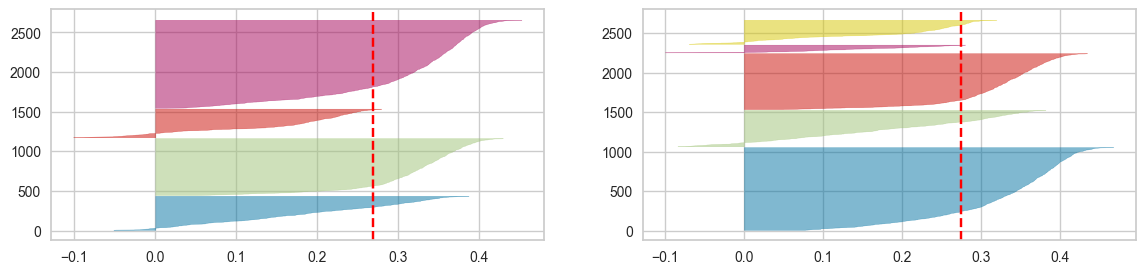

In [35]:
from yellowbrick.cluster import SilhouetteVisualizer
import math

def plot_silhouette(range_):
    num_tests = len(list(range_))
    num_rows = math.ceil(num_tests/2)
    fig, ax = plt.subplots(num_rows, 2, figsize=(14,3*num_rows), squeeze=False)
    for i, num_clusters in enumerate(range_):

        km = MiniBatchKMeans(n_clusters=num_clusters, random_state=SEED)
        q, mod = divmod(i, 2)

        visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
        visualizer.fit(dataset) 

    fig.savefig('./images/kmeans_silhouette.png')

plot_silhouette(range(4, 6))

# Partitional clustering

Using K-Means, actually MiniBatchKMeans

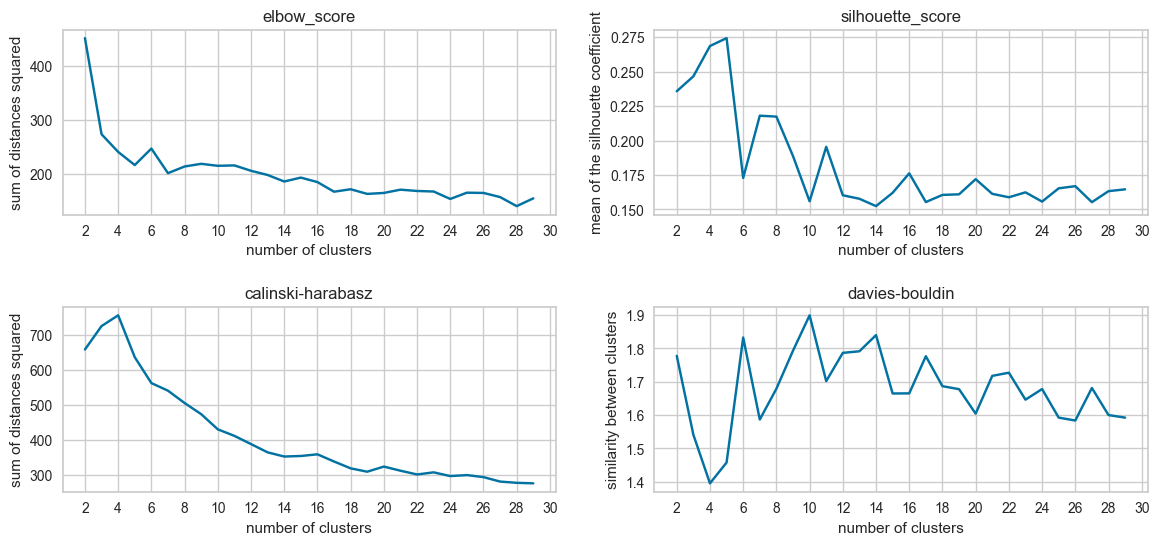

In [20]:
metrics = clustering_metrics(dataset, 'kmeans', range(2, 30), plot=True, save=True)

# Hierarchical clustering

In [47]:
def visualize_dendrogram(dataset, n_clusters=None):
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=n_clusters).fit(dataset)
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1 
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    plt.figure(figsize=(12, 8))
    plt.title('Hierarchical clustering')
    plt.xlabel('Instances in each cluster')
    dendrogram(linkage_matrix, truncate_mode="level", p=3)

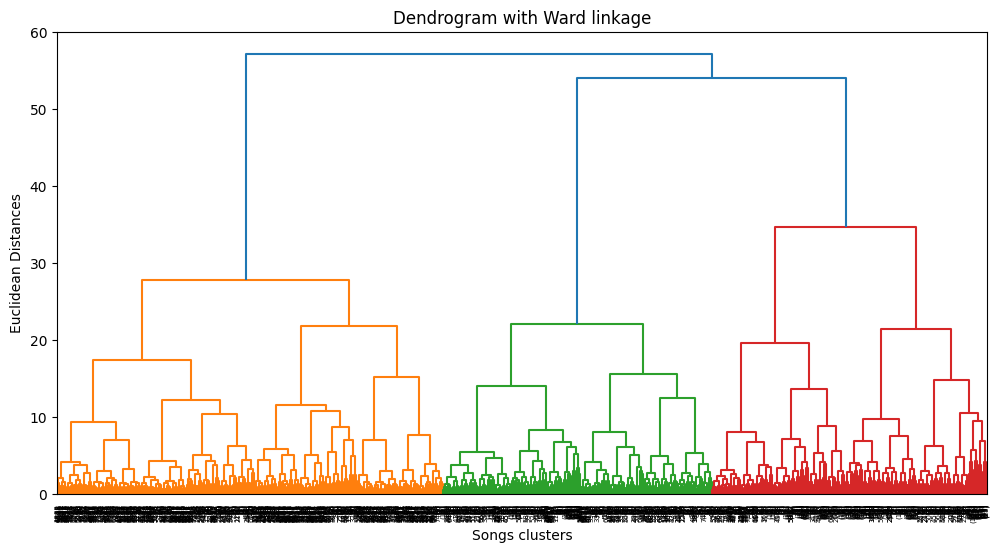

In [11]:
plt.figure(figsize=(12, 6)) 
dendro = shc.dendrogram(shc.linkage(dataset, method="ward"), truncate_mode="level", p=10) 
plt.title("Dendrogram with Ward linkage")  
plt.ylabel("Euclidean Distances")  
plt.xlabel("Songs clusters")  
#plt.show()
plt.savefig('./images/dendro_ward.png')

# Probabilistic clustering

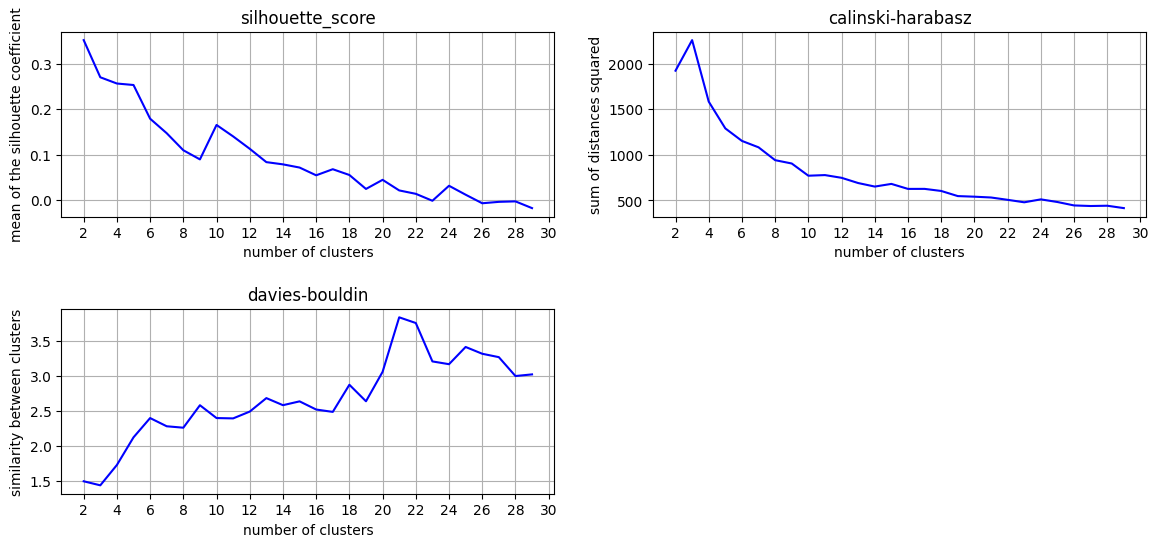

In [18]:
metrics = clustering_metrics(dataset, 'gaussian', range(2, 30), plot=True, save=True)

Text(0.5, 0, 'n_components')

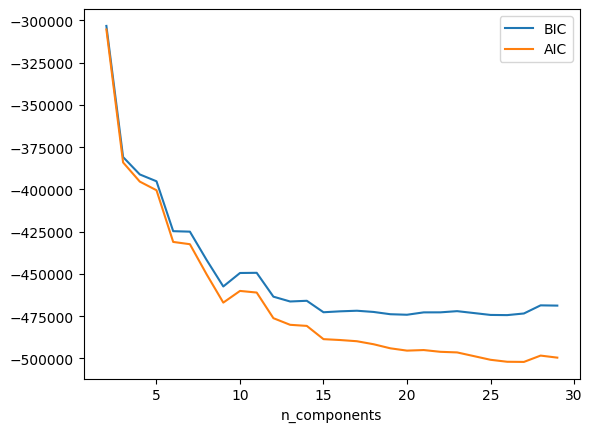

In [31]:
n_components = np.arange(2, 30)
models = [GaussianMixture(n, random_state=SEED).fit(dataset)
          for n in n_components]

plt.plot(n_components, [m.bic(dataset) for m in models], label='BIC')
plt.plot(n_components, [m.aic(dataset) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

# Visualization

In [40]:
def visualize_clusters(model_str, n_clusters, reducer=TSNE, save=False):
    reducer = reducer(n_components=2, random_state=SEED)

    if model_str == 'kmeans':            
        model = MiniBatchKMeans(n_clusters=n_clusters, random_state=SEED)
        plt.title('KMeans')
    elif model_str == 'agg_complete':
        plt.title('Agglomerative with Complete Linkage')  
        model = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete')
    elif model_str == 'agg_ward':
        plt.title('Agglomerative with Ward Linkage')  
        model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    elif model_str == 'gaussian':
        plt.title('Gaussian Mixture')  
        model = GaussianMixture(n_components=n_clusters)

    reduced_dataset = reducer.fit_transform(dataset)  
    clusters = model.fit_predict(reduced_dataset)
    
    plt.xlabel('t-sne component 1')
    plt.ylabel('t-sne component 2')
    sns.scatterplot(x=reduced_dataset[:, 0], y=reduced_dataset[:, 1], hue=clusters, palette='pastel', legend=False)
    if save is True: plt.savefig(f'./images/{model_str}_clusters.png')

def visualize_all_models(n_clusters, save=False):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    # plt.subplots_adjust(hspace=0.5)           
    visualize_clusters('kmeans', n_clusters['kmeans'])

    plt.subplot(2, 2, 2)
    # plt.subplots_adjust(hspace=0.5)           
    visualize_clusters('agg_complete', n_clusters['agg_complete'])

    plt.subplot(2, 2, 3)
    # plt.subplots_adjust(hspace=0.5)           
    visualize_clusters('agg_ward', n_clusters['agg_ward'])

    plt.subplot(2, 2, 4)
    # plt.subplots_adjust(hspace=0.5)           
    visualize_clusters('gaussian', n_clusters['gaussian'])
    if save is True: plt.savefig(f'./images/clusters.png')



c:\Users\adrig\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\adrig\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\adrig\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\adrig\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\adrig\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in T

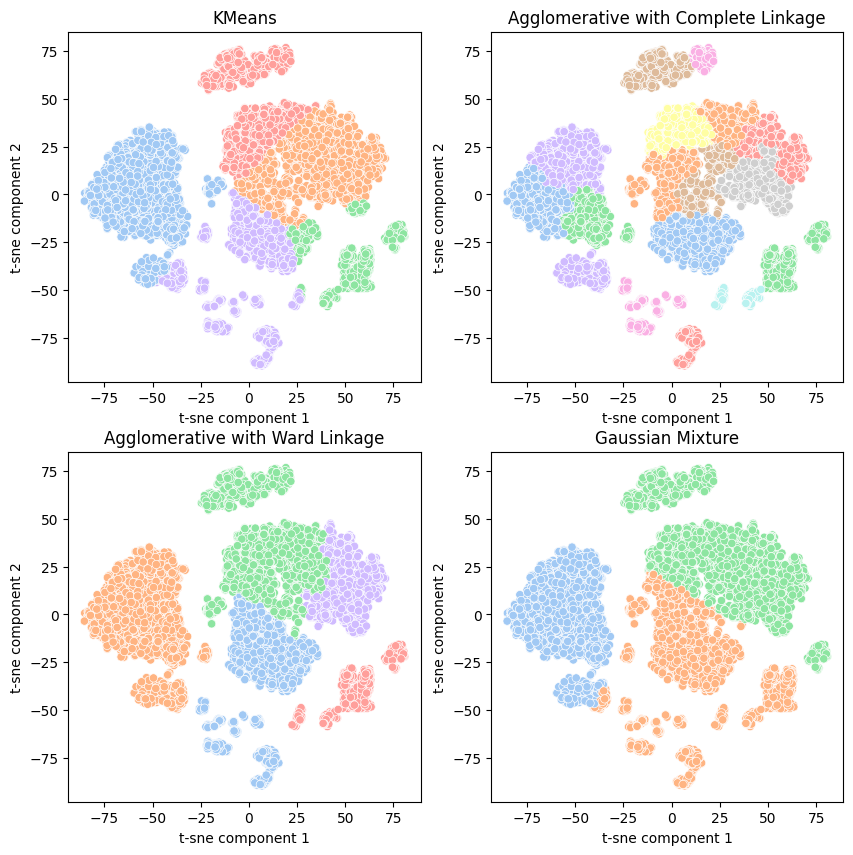

In [42]:
n_clusters = {
    'kmeans' : 5,
    'agg_complete': 17,
    'agg_ward' : 5,
    'gaussian' : 3
}
visualize_all_models(n_clusters, save=True)

c:\Users\adrig\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\adrig\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


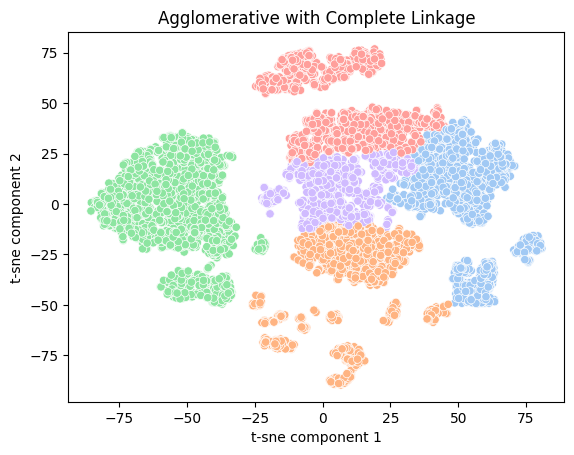

In [43]:
method = 'agg_complete'
n_clusters = 5
reducer = TSNE
#reducer = umap.UMAP

visualize_clusters(method, n_clusters, reducer)

# Obtaining the original "labeled" dataset

In [55]:
labels = AgglomerativeClustering(n_clusters=5, linkage='ward').fit_predict(dataset)
labels = [str(f'{l}_') for l in labels]

In [56]:
original = scaler.inverse_transform(dataset)
df = pd.DataFrame(original, columns=spotify.columns[3:])
df['label'] = labels
df.head()

df.to_csv('./dataset/labeled_dataset.csv', index=False)